In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy


def read_arduino_2ch_binary(number_readings=1, data_type=numpy.float32, error_value=numpy.NaN, 
                 serial_port='COM3', baud_rate=115200, timeout=2, delay=228,
                 startup_message='Yours sincerely, Arduino'): 
    '''
    Returns number_readings (default 1) voltage measurements as binary data from Arduino 
    attached to serial_port at baud_rate with specified timeout.
    Arduino should give a suitable startup message (string).  
    Returns a numpy array of shape (2, number_readings), of type data_type, and a numpy
    array of timestamps of same shape and type numpy.float32. 
    Returns element with error_value if value cannot be converted to type data_type, but
    attempts to correct timestamp array for errors.
    '''
    if number_readings < 1: number_readings = 1 
    numeric_values = numpy.zeros((2, number_readings), dtype=data_type) 
    time_diffs = numpy.zeros((number_readings,), dtype=data_type) 
    
    import serial
    with serial.Serial(port=serial_port, baudrate=baud_rate, timeout=timeout) as arduino:
        arduino.read_until(startup_message.encode()) 
        for i in range(number_readings):
            binary_data = arduino.read(size=6) 
            try: 
                numeric_values[0, i] = data_type((binary_data[0] + (binary_data[1]*2**8))*5/1023) 
                numeric_values[1, i] = data_type((binary_data[2] + (binary_data[3]*2**8))*5/1023) 
                time_diffs[i] = data_type(binary_data[4] + (binary_data[5]*2**8)) 
            except (ValueError, IndexError):
                numeric_values[0, i] = error_value
                numeric_values[1, i] = error_value
                time_diffs[i] = 0
    
    timestamps = reconstruct_timestamps(time_diffs, 2, delay)
    
    return numeric_values, timestamps*1e-6


def reconstruct_timestamps(diffs, n_channels, delay=228):
    '''
    More robust reconstruction of corrected timestamp array: any zero values
    in 'diffs' due to errors are replaced with the modal value of the rest
    of the array, before making the cumulative sum.
    '''
    from scipy.stats import mode
    try: # Determine the most common (mode) of the valid time_diff values
        mode_diff = mode(diffs[diffs != 0]).mode[0]     
    except IndexError: # If ALL diffs are zero, due to errors, mode.mode = []
        print('Your Arduino sketch is not compatible with this function!')
        mode_diff = 0 #  This will still return array of zeros for timestamps
        
    timestamps = numpy.where(diffs == 0, # replace invalid values
                             mode_diff, # with most common valid value
                             diffs).cumsum() # then take cumulative sum
    return numpy.array([timestamps + i*delay for i in range(n_channels)])


def read_and_discard(number_to_read=1, number_to_discard=100, **kwds):
    '''
    Returns number_to_read (default 1) samples from Arduino by binary transfer, 
    after discarding the first number_to_discard samples (default 100).
    Other arguments passed using **kwds.
    '''
    kwds.pop('number_readings', None) 
    sigs, time = read_arduino_2ch_binary(number_readings=number_to_read+number_to_discard, **kwds)
    return sigs[:, number_to_discard:], time[:, number_to_discard:]

def plot_signals(signals, times, plot=True):
    '''Plots a graph of the 2D numpy array 'signals' of
    two-channel data, vs times array of same shape, if plot=True.'''
    if plot: # only plot graph if plot=True
        plt.figure(figsize=(10,2))
        plt.plot(times[0], signals[0], 'b', label='A0')
        plt.plot(times[1], signals[1], 'r', label='A1')
        plt.legend()
        plt.xlabel('time (s)'); plt.ylabel('ADC voltage (V)')
        plt.show()
        
def FFT(signals, times, plot=True):
    '''
    Determine and plot (positive frequency) FFT, and from these 
    determine the phase-shift between 2 datasets using 
    cross-correlation from Fast Fourier Transforms.
    signals and times are arrays of the same shape, providing a
    timestamp for each signal. 
    Returns arrays of frequencies and amplitudes of (non-zero frequency) 
    fundamental tone, and the phase shift between the signals.
    '''   
    from scipy.fftpack import fft, ifft
    from scipy.signal import argrelmax, argrelmin
    
    ffts = fft(signals) # Only calculate this once, it does all arrays together! 
    yf = 2.0/len(signals[0]) * numpy.abs(ffts[:, :len(signals[0])//2])[:, 1:] 
    xf = numpy.linspace(0.0, 
                        len(times[0])/(2.0*(times[0,-1]-times[0,0])), 
                        len(times[0])//2)[1:]
    freq = xf[numpy.argmax(yf, axis=1)]
    amp = numpy.max(yf, axis=1) 
    angle = 360*freq[0]*(times - times[0,0]) 
    angle = angle[0] - angle[1,0] 
    correlation = ifft(ffts[0] * ffts[1].conj()).real 
    try:
        phase = angle[argrelmax(correlation)[0][0]] % 360 
        phase_err = 2 * abs(angle[1]-angle[0]) / numpy.sqrt(len(argrelmax(correlation)[0]))
    except IndexError: # no maxima in correlation
        phase = 0
        phase_err = 0
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(211)
        plt.plot(xf, yf[0], 'b', label='A0')
        plt.plot(xf, yf[1], 'r', label='A1')
        plt.legend()
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude')
              
        plt.subplot(223)
        plt.plot(angle, correlation)
        plt.xlabel('angle (degrees)'); plt.ylabel('cross-correlation')
        
        plt.subplot(224)
        try:
            length = argrelmin(correlation)[0][1]
        except IndexError: # no minima in correlation
            length = -1 # plot all of data
        plt.plot(angle[:length], correlation[:length], marker='o')
        plt.xlabel('angle (degrees)')
        
        plt.tight_layout()
        plt.show()
        
        print('Ch0: Fundamental frequency at {}, with amplitude {}.'.format(freq[0], amp[0]))
        print('Ch1: Fundamental frequency at {}, with amplitude {}.'.format(freq[1], amp[1]))
        print('Nyquist frequency as last point in FFT = {}'.format(xf[-1]))
        print('Phase-shift = {} +/- {}'.format(phase, phase_err))
        
    return freq, amp, (phase, phase_err)

def frequency_sweep(freqs, number_readings=2000, duration=3, plot=False):
    import simpleaudio as sa
    # set up arrays for signal data
    sample_rate = 44100 
    samples = int(duration)*sample_rate
    time = numpy.linspace(0, int(duration), samples, False)
    # set up arrays for measurement data
    fft_freqs = numpy.zeros((len(freqs), 2), dtype=numpy.float32) 
    amplitudes = numpy.zeros_like(fft_freqs) 
    phase = numpy.zeros_like(fft_freqs) 
    
    for i, freq in enumerate(freqs): # loop over listed frequencies
        if plot: print('\n', freq, 'Hz')
        # generate and play audio signals
        audio = numpy.zeros((samples, 2))
        audio[:,0] = 1 + numpy.sin(2*numpy.pi*freq*time) # 'left' - sine
        audio[:,1] = 1 + numpy.cos(2*numpy.pi*freq*time) # 'right' - cosine
        audio *= 32767 / numpy.max(numpy.abs(audio)) # normalize to 16-bit
        audio = audio.astype(numpy.int16) # convert to 16-bit datatype
        play_obj = sa.play_buffer(audio, 2, 2, sample_rate) # start playback
        # acquire measurement from Arduino
        signal, times = read_and_discard(number_to_read=number_readings, delay=228)
        # plot and process acquired signals
        plot_signals(signal, times, plot)
        fft_freqs[i], amplitudes[i], phase[i] =  FFT(signal, times, plot)
        # wait for playback to finish before continuing
        play_obj.wait_done() 
        
    return fft_freqs.T, amplitudes.T, phase.T

def plot_sweep(freqs, amplitudes, phase):
        
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(211)
    plt.plot(freqs[0], amplitudes[0], 'b', label='A0') # could use errorbar...
    plt.plot(freqs[1], amplitudes[1], 'r', label='A1') 
    plt.xscale('log'); plt.grid(which='both', axis='both')               
    plt.ylabel('FFT amplitude (V)'); plt.legend()

    ax2 = plt.subplot(212, sharex=ax1)
    phases = ((phase[0] + 180) % 360) - 180 # shift into range +/- 180
    plt.errorbar(freqs[0], phases, yerr=phase[1]) 
    plt.ylim(-180, 180); plt.yticks(ticks=[-180, -90, 0, 90, 180])
    plt.xscale('log');     plt.grid(which='both', axis='both')               
    plt.xlabel('FFT frequency (Hz)'); plt.ylabel('Phase-shift (degrees)')

    plt.setp(ax1.get_xticklabels(), visible=False)
    fig.align_ylabels()
    plt.tight_layout()
    plt.show()
    

Sample rate = 1973.1027814898835 samples/Ch/second


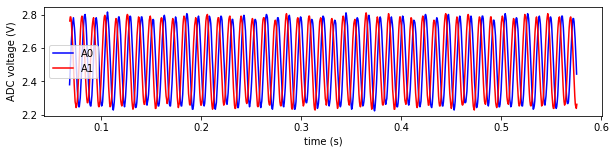

In [10]:
signals, times = read_and_discard(number_to_read=1000, delay=228)
print('Sample rate = {} samples/Ch/second'.format(len(times[0])/(times[0,-1]-times[0,0])))
plot_signals(signals, times)

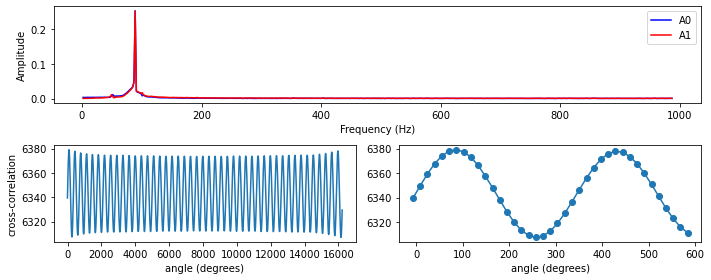

Ch0: Fundamental frequency at 88.96756028762, with amplitude 0.252081036567688.
Ch1: Fundamental frequency at 88.96756028762, with amplitude 0.2514357268810272.
Nyquist frequency as last point in FFT = 986.5513907449417
Phase-shift = 86.09207153320312 +/- 4.659894616542588
[88.96756029 88.96756029]
[0.25208104 0.25143573]
(86.09207153320312, 4.659894616542588)


In [11]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

Sample rate = 1968.9794761050864 samples/Ch/second


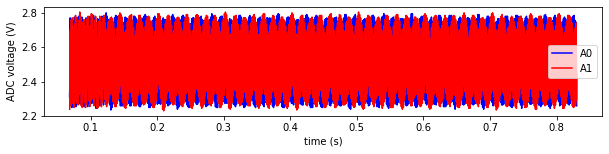

In [13]:
# Mystery Signal
signals, times = read_and_discard(number_to_read=1500, delay=228)
print('Sample rate = {} samples/Ch/second'.format(len(times[0])/(times[0,-1]-times[0,0])))
plot_signals(signals, times)

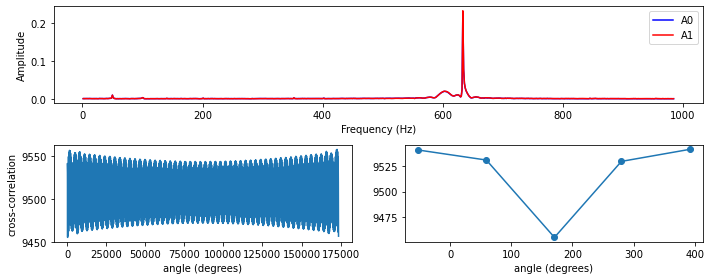

Ch0: Fundamental frequency at 633.5434629390198, with amplitude 0.22905446588993073.
Ch1: Fundamental frequency at 633.5434629390198, with amplitude 0.23357100784778595.
Nyquist frequency as last point in FFT = 984.4897380525432
Phase-shift = 31.376739501953125 +/- 10.149730462571643
[633.54346294 633.54346294]
[0.22905447 0.23357101]
(31.376739501953125, 10.149730462571643)


In [14]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [21]:
print ("Samples per cycle")
print (1968.9794761050864/633.5434629390198)

Samples per cycle
3.1078838174273855


In [32]:
print("Max voltage gain is about 1.9, any more and the audio will clip and cannot reach its full amplitude")

Max voltage gain is about 1.9, any more and the audio will clip and cannot reach its full amplitude


In [2]:
def plot_opamp_signals(signals, times, plot=True):
    '''Display data, on different scales, if plot=True.'''
    if plot:
        plt.figure(figsize=(10,2))
        plt.plot(times[0], signals[0], 'b', label='A0')
        plt.xlabel('time (s)'); plt.ylabel('A0 Voltage (V)')
        # legend is a bit more complicated with twinx...
        lines, labels = plt.gca().get_legend_handles_labels()
        ax = plt.gca().twinx() # second y-axis that shares x-axis
        ax.plot(times[1], signals[1], 'r', label='A1') 
        plt.ylabel('A1 Voltage (V)')
        lines2, labels2 = ax.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2)
        plt.show()   

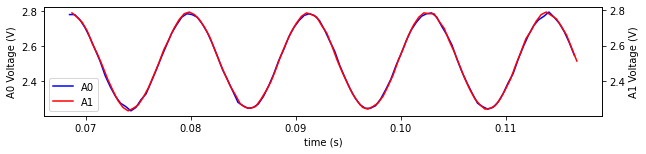

In [28]:
signals, times = read_and_discard(number_to_read=2000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 
# Left Channel

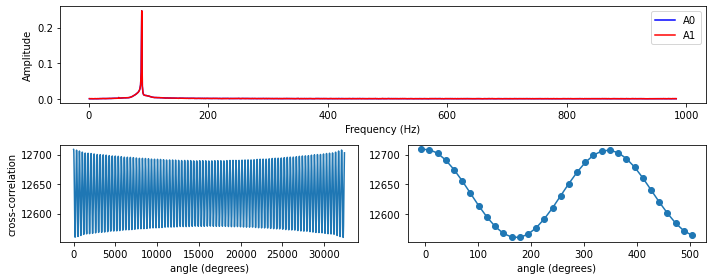

Ch0: Fundamental frequency at 88.60018756297288, with amplitude 0.24702535569667816.
Ch1: Fundamental frequency at 88.60018756297288, with amplitude 0.24719615280628204.
Nyquist frequency as last point in FFT = 983.462081948999
Phase-shift = 349.1979675292969 +/- 3.2998204191035545
[88.60018756 88.60018756]
[0.24702536 0.24719615]
(349.1979675292969, 3.2998204191035545)


In [29]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

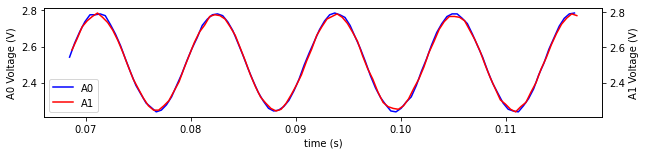

In [30]:
signals, times = read_and_discard(number_to_read=2000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 
# Right Channel

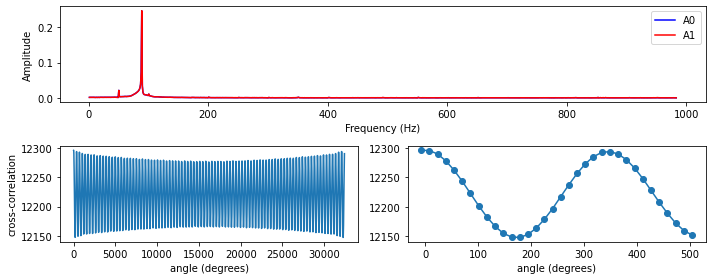

Ch0: Fundamental frequency at 88.60018756297288, with amplitude 0.24675798416137695.
Ch1: Fundamental frequency at 88.60018756297288, with amplitude 0.2469434291124344.
Nyquist frequency as last point in FFT = 983.462081948999
Phase-shift = 349.1979675292969 +/- 3.2998204191035545
[88.60018756 88.60018756]
[0.24675798 0.24694343]
(349.1979675292969, 3.2998204191035545)


In [39]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_signal(signal):
    '''
    Plots a graph of the numpy array 'signal'.
    '''
    mean = numpy.mean(signal) 
    std_error = numpy.std(signal)/numpy.sqrt(len(signal))
    
    plt.figure(figsize=(10,2))
    plt.plot(signal, marker='o', linestyle='none')
    plt.axhline(mean-std_error, color='r')
    plt.axhline(mean, color='k')
    plt.axhline(mean+std_error, color='r')
    plt.xlabel('Sample no.'); plt.ylabel('ADC0 voltage (V)')
    plt.show()
    
import numpy

def read_arduino(number_readings=1, data_type=numpy.float32, error_value=numpy.NaN,
                 serial_port='COM3', baud_rate=115200, timeout=2, 
                 terminator='\r\n', startup_message='Yours sincerely, Arduino'): 
    '''
    Returns number_readings (default 1) voltage measurements from Arduino attached to 
    serial_port at baud_rate with specified timeout.
    Each voltage reading from Arduino should be terminated with terminator (string), and 
    it should give a suitable startup message (string).  
    Returns a numpy array of length number_readings, of type data_type. 
    Returns element with error_value if value cannot be converted to type data_type.
    '''
    if number_readings < 1: number_readings = 1 # need at least 1 reading!
    numeric_values = numpy.zeros((number_readings,), dtype=data_type)
    
    import serial
    with serial.Serial(port=serial_port, baudrate=baud_rate, timeout=timeout) as arduino:
        # Connect, and read until distinctive startup_message
        # Remember that exiting the 'with' block closes the connection automatically.
        arduino.read_until(startup_message.encode()) # string.encode() -> bytearray
        for i in range(number_readings): 
            value = arduino.read_until(terminator.encode()) # string.encode() -> bytearray
            try: # try to convert returned value to type data_type
                numeric_values[i] = data_type(value.decode().strip())
            except ValueError: # If we fail to convert data to type data_type, then
                numeric_values[i] = error_value # return error_value instead.
    return numeric_values


In [4]:
import serial

def read_arduino(number_readings=1, data_type=numpy.float32, error_value=numpy.NaN,
                 serial_port='COM3', baud_rate=115200, timeout=2, 
                 terminator='\r\n', startup_message='Yours sincerely, Arduino'): 
    '''
    Returns number_readings (default 1) voltage measurements from Arduino attached to 
    serial_port at baud_rate with specified timeout.
    Each voltage reading from Arduino should be terminated with terminator (string), and 
    it should give a suitable startup message (string).  
    Returns either a numpy array containing a single value (num_readings <= 1), or of length 
    number_readings, of type data_type. 
    Returns element with error_value if value cannot be converted to type data_type.
    '''
    if number_readings < 1: number_readings = 1 # need at least 1 reading!
    # Define an empty array of appropriate size and datatype
    numeric_values = numpy.zeros((number_readings,), dtype=data_type)
    
    with serial.Serial(port=serial_port, baudrate=baud_rate, timeout=timeout) as arduino:
        # Connect, and read until distinctive startup_message
        arduino.read_until(startup_message.encode()) # string.encode() -> bytearray
        for i in range(number_readings): # Gather the appropriate number of measurements
            value = arduino.read_until(terminator.encode()) # string.encode() -> bytearray
            try: # try to convert returned value to type data_type
                numeric_values[i] = data_type(value.decode().strip())
            except ValueError: # If we fail to convert data to type data_type, then
                numeric_values[i] = error_value # return error_value instead.
    # Remember that exiting the 'with' block closes the connection automatically.
    return numeric_values


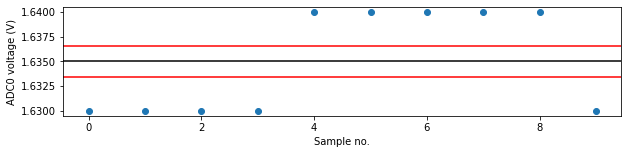

In [78]:

voltages = read_arduino(number_readings=10)
plot_signal(voltages)



In [5]:
# Comment on result, very close to 5 - 3.3 = 1.7 V, will be some discrepancy due to the equipment used. 
# Value of 1.635 +/- 0.002 V (using std error)

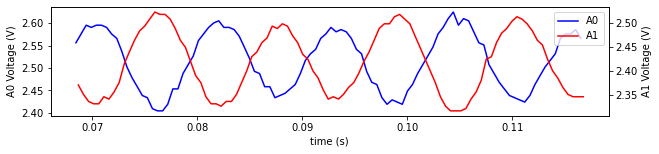

In [8]:
signals, times = read_and_discard(number_to_read=2000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 

In [25]:
# V1 is A0, Vout is A1 (again Vout is approximately 4% smaller than V1 in accordance with 4% discrepancy in q3)

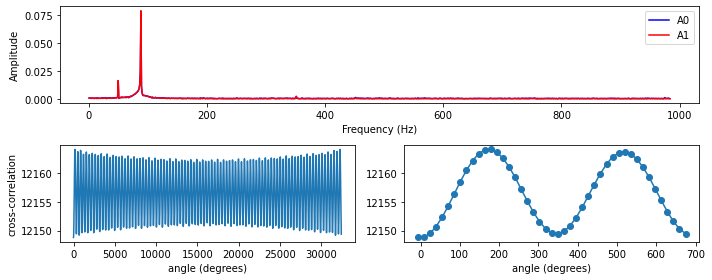

Ch0: Fundamental frequency at 88.60018756297288, with amplitude 0.07821466773748398.
Ch1: Fundamental frequency at 88.60018756297288, with amplitude 0.07860295474529266.
Nyquist frequency as last point in FFT = 983.462081948999
Phase-shift = 179.00076293945312 +/- 3.281436875400801
[88.60018756 88.60018756]
[0.07821467 0.07860295]
(179.00076293945312, 3.281436875400801)


In [9]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [10]:
# Phase shift of 179 +/- 3 degrees, perfectly out of phase

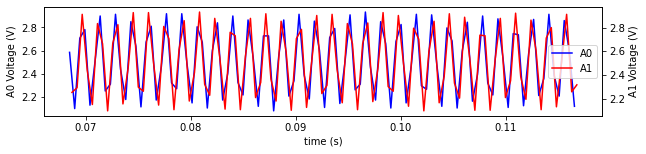

In [26]:
signals, times = read_and_discard(number_to_read=2000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 

In [5]:
# Now in phase, A0 is V1 (left) , A1 is V2 (right), match before the amplifier, 633 with higher amplitude 0.37/38

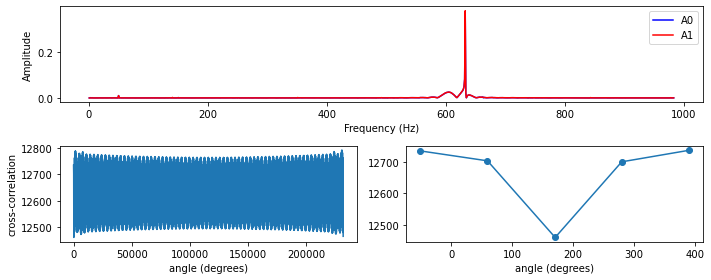

Ch0: Fundamental frequency at 632.9991178110173, with amplitude 0.3721963167190552.
Ch1: Fundamental frequency at 632.9991178110173, with amplitude 0.3797355592250824.
Nyquist frequency as last point in FFT = 983.462081948999
Phase-shift = 31.040496826171875 +/- 8.77781183531439
[632.99911781 632.99911781]
[0.37219632 0.37973556]
(31.040496826171875, 8.77781183531439)


In [27]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

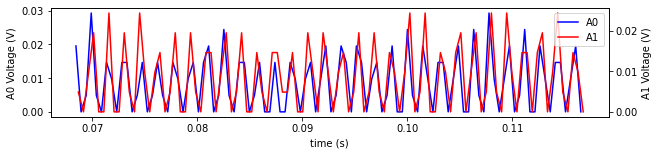

In [20]:
signals, times = read_and_discard(number_to_read=2000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 

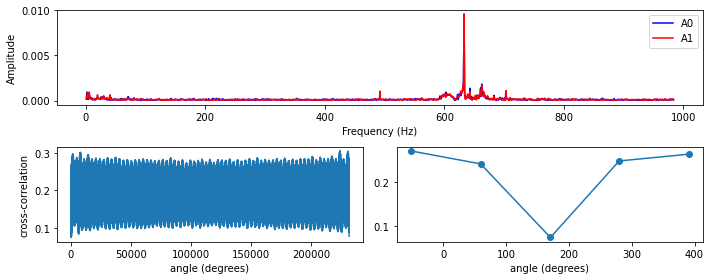

Ch0: Fundamental frequency at 632.9991178110173, with amplitude 0.009582112543284893.
Ch1: Fundamental frequency at 632.9991178110173, with amplitude 0.009604149498045444.
Nyquist frequency as last point in FFT = 983.462081948999
Phase-shift = 31.040496826171875 +/- 8.77781183531439
[632.99911781 632.99911781]
[0.00958211 0.00960415]
(31.040496826171875, 8.77781183531439)


In [21]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [17]:
# Phase shift of 30 and frequency of 633 like before. Falls to 0 frequently as arduino is too imprecise to measure the very small voltages at each trough.
# Tiny amplitude, very weak voltage signal.

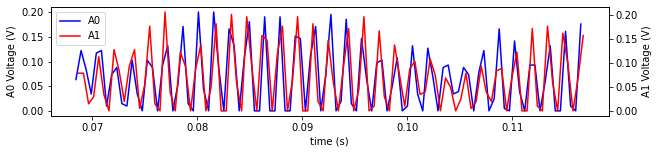

In [23]:
signals, times = read_and_discard(number_to_read=2000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 

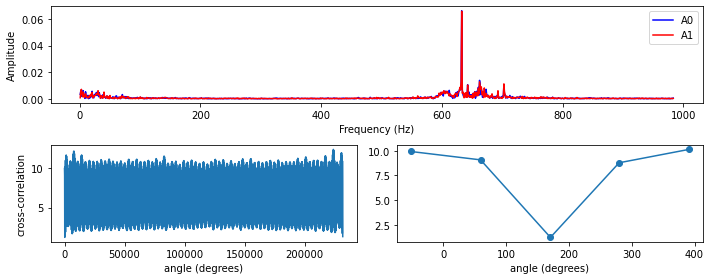

Ch0: Fundamental frequency at 632.9991178110173, with amplitude 0.06615998595952988.
Ch1: Fundamental frequency at 632.9991178110173, with amplitude 0.06583790481090546.
Nyquist frequency as last point in FFT = 983.462081948999
Phase-shift = 31.040496826171875 +/- 8.77781183531439
[632.99911781 632.99911781]
[0.06615999 0.0658379 ]
(31.040496826171875, 8.77781183531439)


In [24]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [5]:
# Approximately 30 degrees out of phase just like before and frequency of about 633 just like before.
# Wave pattern is much easier to observe, small voltages have been multiplied by 10, meaning the arduino can read it more precisely
# Small amplitude, stronger signal (still weak though)

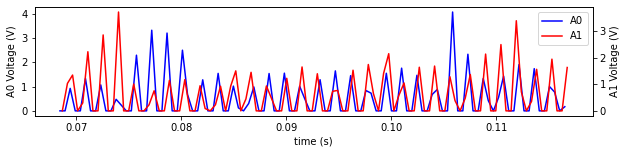

In [21]:
# Designed gain 210 and 46.4 decibel gain
signals, times = read_and_discard(number_to_read=2000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 

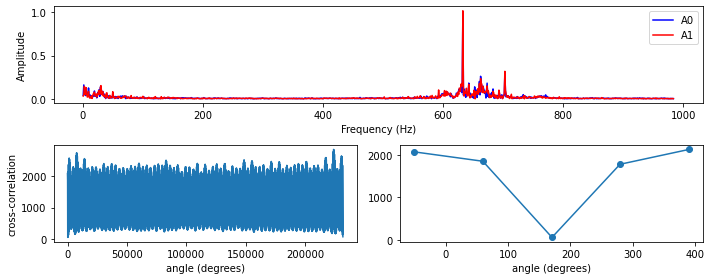

Ch0: Fundamental frequency at 632.9991178110173, with amplitude 1.0083749294281006.
Ch1: Fundamental frequency at 632.9991178110173, with amplitude 1.0196540355682373.
Nyquist frequency as last point in FFT = 983.462081948999
Phase-shift = 31.040496826171875 +/- 8.77781183531439
[632.99911781 632.99911781]
[1.0083749 1.019654 ]
(31.040496826171875, 8.77781183531439)


In [22]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

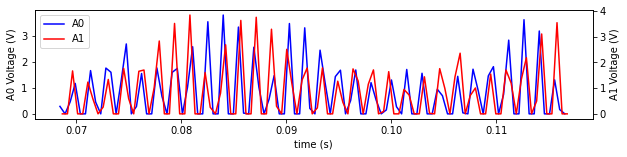

In [18]:
signals, times = read_and_discard(number_to_read=20000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 

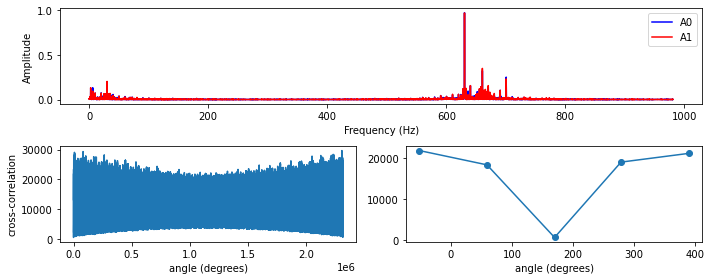

Ch0: Fundamental frequency at 630.554016609038, with amplitude 0.9738607406616211.
Ch1: Fundamental frequency at 630.554016609038, with amplitude 0.9702318906784058.
Nyquist frequency as last point in FFT = 980.698337544528
Phase-shift = 29.530029296875 +/- 2.7633444486542835
[630.55401661 630.55401661]
[0.97386074 0.9702319 ]
(29.530029296875, 2.7633444486542835)


In [19]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

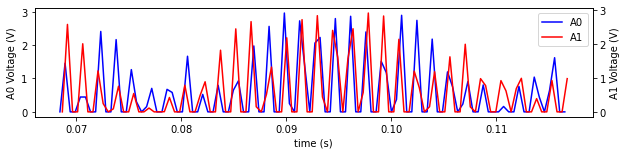

In [25]:
# An appropriate value of the corner frequency would be about 723Hz, above the carrier signal (to pass without any information loss) but not too much higher (little high frequency noise is passed without attenuation)
signals, times = read_and_discard(number_to_read=50000)
plot_opamp_signals(signals[:, :100], times[:, :100]) 

In [ ]:
# Voltage amplitude is slightly lower than before, the voltage across the entire wave is offset by approximately 1 volt.
# Potentially a reduction in systematic error.

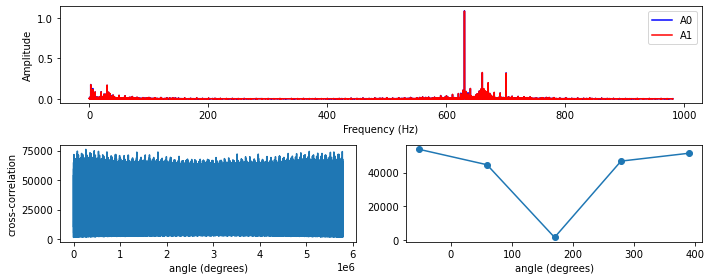

Ch0: Fundamental frequency at 630.3784168714568, with amplitude 1.0892075300216675.
Ch1: Fundamental frequency at 630.3784168714568, with amplitude 1.0853936672210693.
Nyquist frequency as last point in FFT = 980.5145621807832
Phase-shift = 29.421539306640625 +/- 1.7471514746143968
[630.37841687 630.37841687]
[1.0892075 1.0853937]
(29.421539306640625, 1.7471514746143968)


In [26]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [27]:
# 630 V with amplitude 1.09